loaded efx algorithm


number of players:  3
number of item types:  2
number of items of each type (comma-separated):  40,40
valuation for player 0 (comma-separated):  2,1
valuation for player 1 (comma-separated):  1,5
valuation for player 2 (comma-separated):  6,100


APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
COULD NOT APPLY U0
APPLIED U2
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
AP

(3,
 2,
 array([[19., 13.],
        [19., 13.],
        [ 2., 14.]]),
 array([40., 40.]),
 array([[  2.,   1.],
        [  1.,   5.],
        [  6., 100.]]))

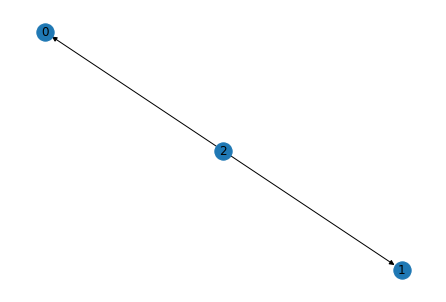

In [14]:
%run efx_charity
run_and_check(draw=True)